# Наумкин Владимир, С01-119.

## Задача 3. Posterior Sampling в задаче RL.

Буду использовать семинары 25 и 27 (гитхаб и видео). Статья https://arxiv.org/pdf/1306.0940.

### Подключим библиотеки, уберём предупреждения

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Определим среду

In [2]:
class RiverSwim:
    def __init__(self, 
                 isc  = 4, # число состояний (без учета крайних)
                 ms   = 16, # максимальное число шагов
                 lr   = 5/1000, # награда слева (по течению)
                 rr   = 1.0, # награда справа (против течения)
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = ms
        self._interm_states = isc
        self._steps = 0
        self._current_state = 1
        self.lr = lr
        self.rr = rr
    @property
    def action_count(self):
        return 2
    @property
    def states_count(self):
        return 2 + self._interm_states
    def _get_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]
        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]
    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1
        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr
        self._steps += 1
        return self._current_state, reward, False

### Обычный (эпсилон-жадный) агент

In [3]:
class QLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr
    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    def get_q_matrix(self):
        return self._q_matrix
    def start_episode(self):
        pass
    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = self._q_matrix[state, action] + self._lr*(reward + self._gamma*np.max(self._q_matrix[next_state]) - self._q_matrix[state, action])
        return

### Обучение обычного агента

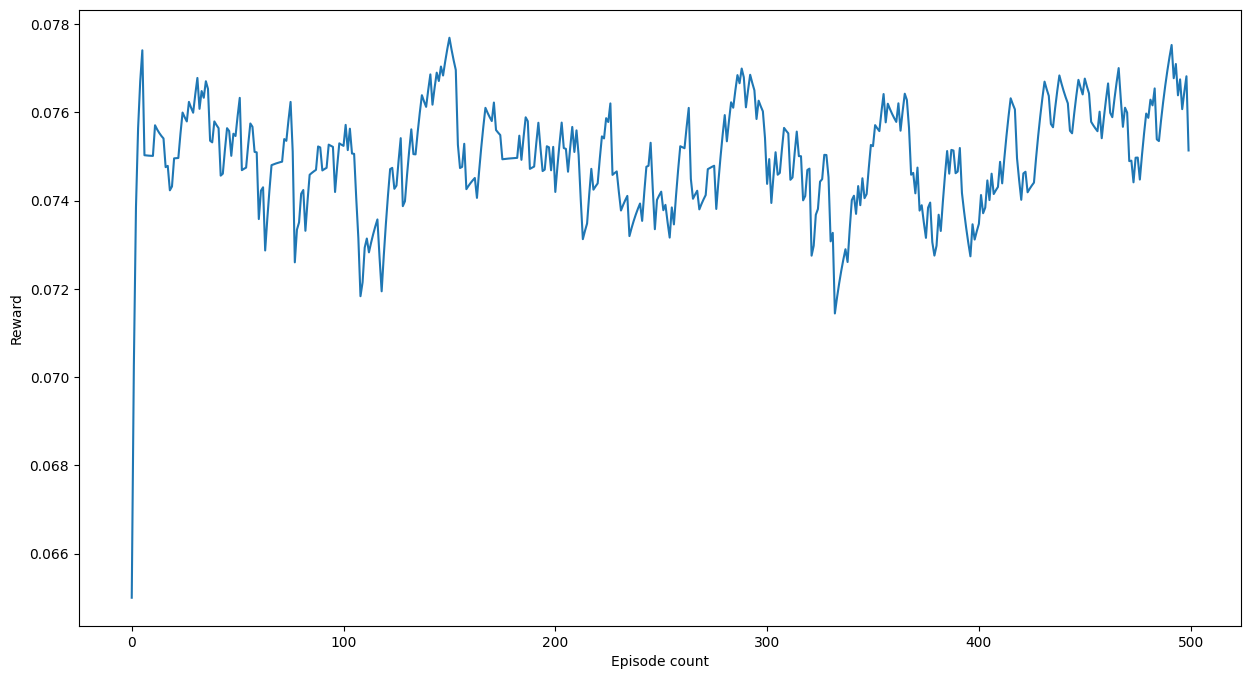

In [4]:
n = 4
ms = 16
episodes = 500
actions = 2
agent = QLearningAgent(2+n, actions)
episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)
    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        ep_reward += reward
    episode_rewards.append(ep_reward)
plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

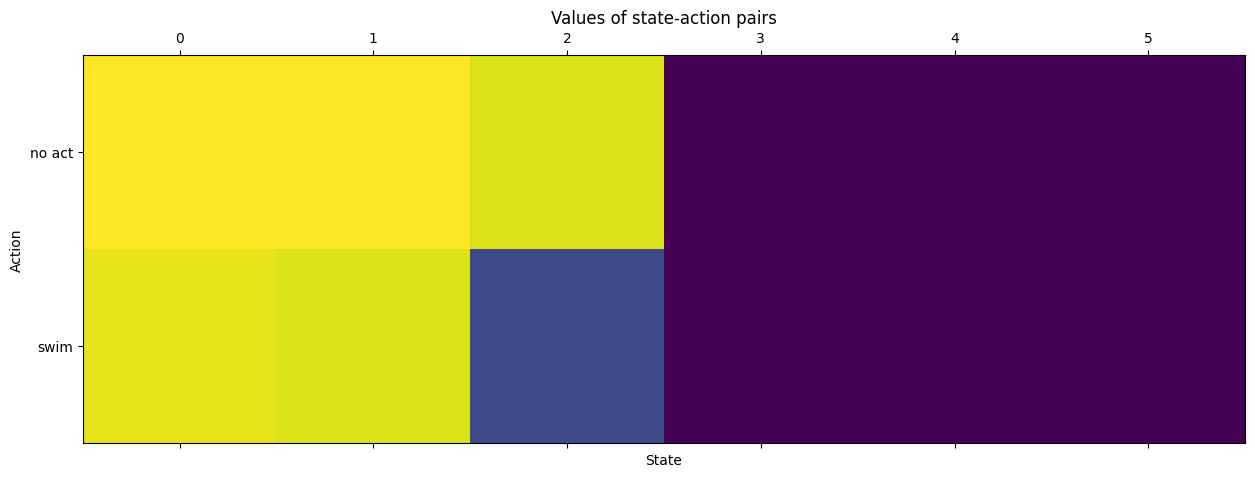

In [5]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

Как мы видим, обычный агент доплывает максимум до середины реки и всегда предпочитает плыть по течению, а не против него.

### Улучшенный (posterior sampling) агент

Этот агент будет пытаться строить матрицу переходов, то есть предсказывать вероятности перейти из одного состояния в другое в зависимости от действия. Напомним, что эти вероятности задаются средой и агент о них не знает. Также агент моделирует матрицу наград, то есть сколько он получит в зависимости от действия в текущем состоянии. При выборе действия в текущем состоянии агент учитывает ожидаемую награду, то есть ценность будущего состояния.

В начале каждого эпизода сэмплируется по Дирихле матрица переходов, а по гамма-нормальному распределению - матрица наград. Также вычисляются ценности состояний. В шаге каждого эпизода действие для текущего состояния выбирается с учётом ожидаемой награды, обновляются параметры распределений. Таким образом, после окончания эпизода сэмплы для нового эпизода будут учитывать предыдущие результаты взаимодействия агента со средой.

Все обозначения взяты из картинки с 27 семинара (см. видео 2020 - 2021 года).

Гамма-нормальное распределение https://en.wikipedia.org/wiki/Normal-gamma_distribution.

Обновление параметров распределений https://en.wikipedia.org/wiki/Conjugate_prior.

In [6]:
class PSAgent:
    def __init__(self, n_states, n_actions, seed = 42):
        self.rs = np.random.RandomState(seed)
        self.n_states = n_states
        self.n_actions = n_actions
        self.T = np.ones((n_states, n_states, n_actions))
        self.mu = np.ones((n_states, n_actions))
        self.alpha = np.ones((n_states, n_actions))
        self.beta = np.ones((n_states, n_actions))
        self.nu = np.ones((n_states, n_actions)) # в Википедии nu правилах обновлений, оно же lambda в гамма-нормальном распределении
        self.S = np.zeros((n_states, n_states, n_actions)) # initial state, final state, action
        self.R = np.zeros((n_states, n_actions))
        self.V = np.zeros(n_states)
    def get_action(self, state):
        return np.argmax(self.R[state] + np.tensordot(self.V, self.S[state], (0, 0)))
    def get_q_matrix(self):
        return self.R + np.tensordot(self.V, self.S, (0, 1))
    def start_episode(self):
        self.S = np.apply_along_axis(self.rs.dirichlet, 1, self.T) # сумма по f (средней оси из 3, то есть 1й при нумерации с 0) Sifa равна 1
        self.R = self.rs.normal(self.mu, 1 / np.sqrt(self.rs.gamma(self.alpha, self.beta) * self.nu))
        self.V = np.max(self.R + np.tensordot(self.V, self.S, (0, 1)), 1) # скалярное произведение единственной оси V по второй оси S, то есть Sia = сумма по f Vf * Sifa; максимум по второй оси (действию)
    def update(self, state, action, reward, next_state):
        self.T[state][next_state][action] += 1
        self.alpha[state][action] += 0.5
        self.beta[state][action] += (self.nu[state][action] * ((reward - self.mu[state][action])**2)) / (2 * (self.nu[state][action] + 1))
        self.mu[state][action] = (reward + self.nu[state][action] * self.mu[state][action]) / (self.nu[state][action] + 1)
        self.nu[state][action] += 1

### Обучение улучшенного агента

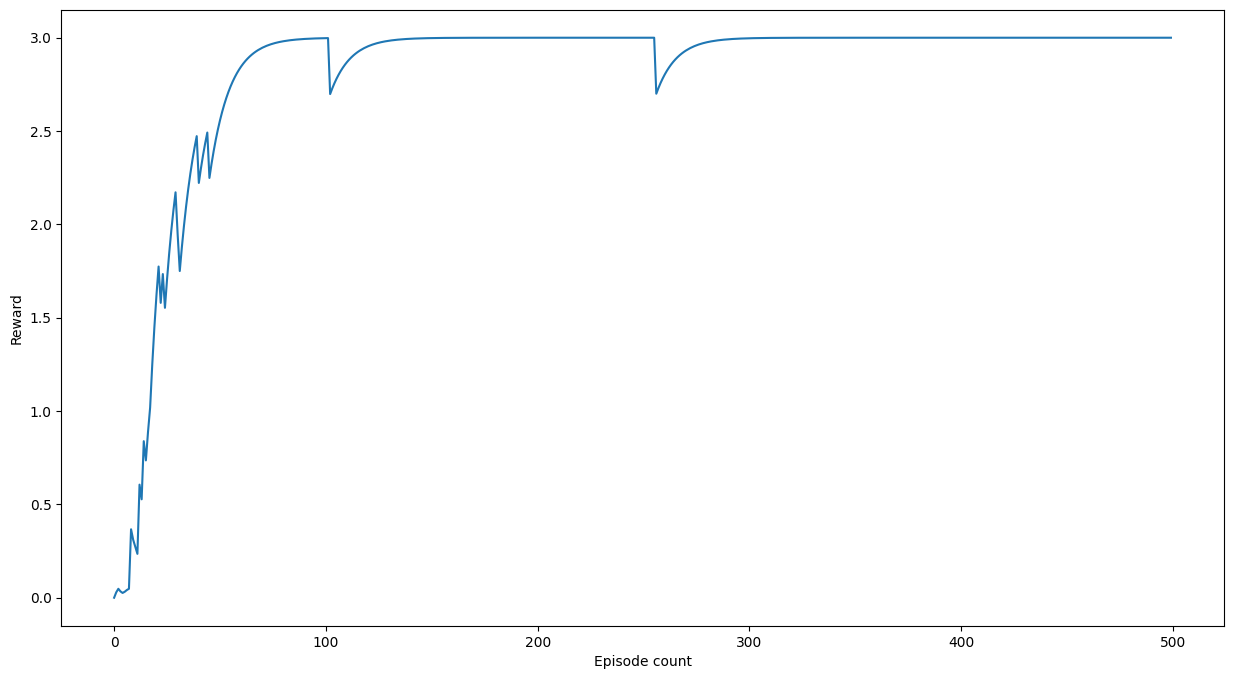

In [7]:
n = 4
ms = 16
episodes = 500
actions = 2
agent = PSAgent(2+n, actions)
episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)
    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        ep_reward += reward
    episode_rewards.append(ep_reward)
plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

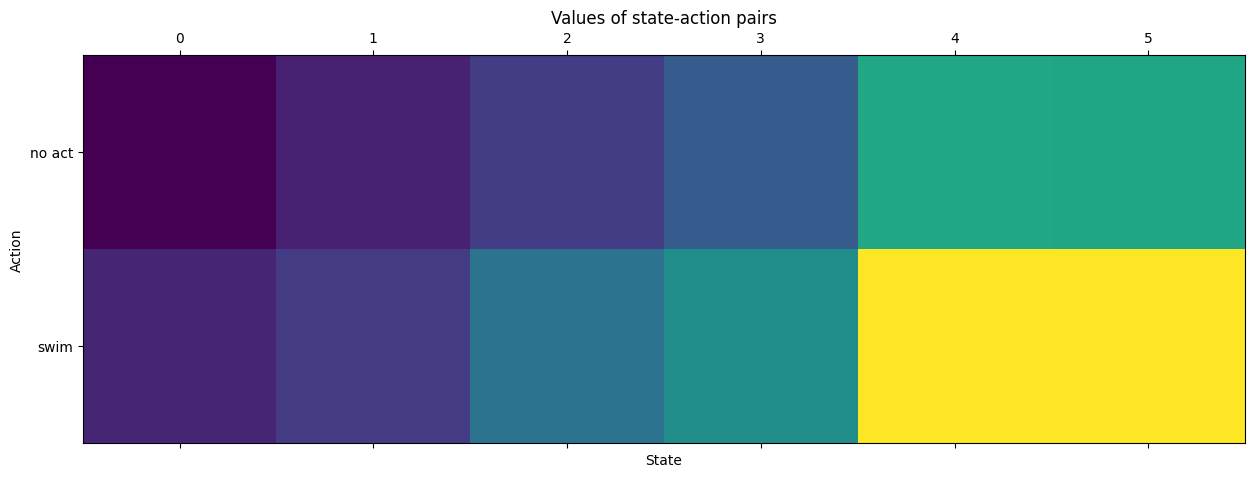

In [8]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

Агент нашёл правильную стратегию - всегда пытаться плыть вправо.

### Увеличим длину реки

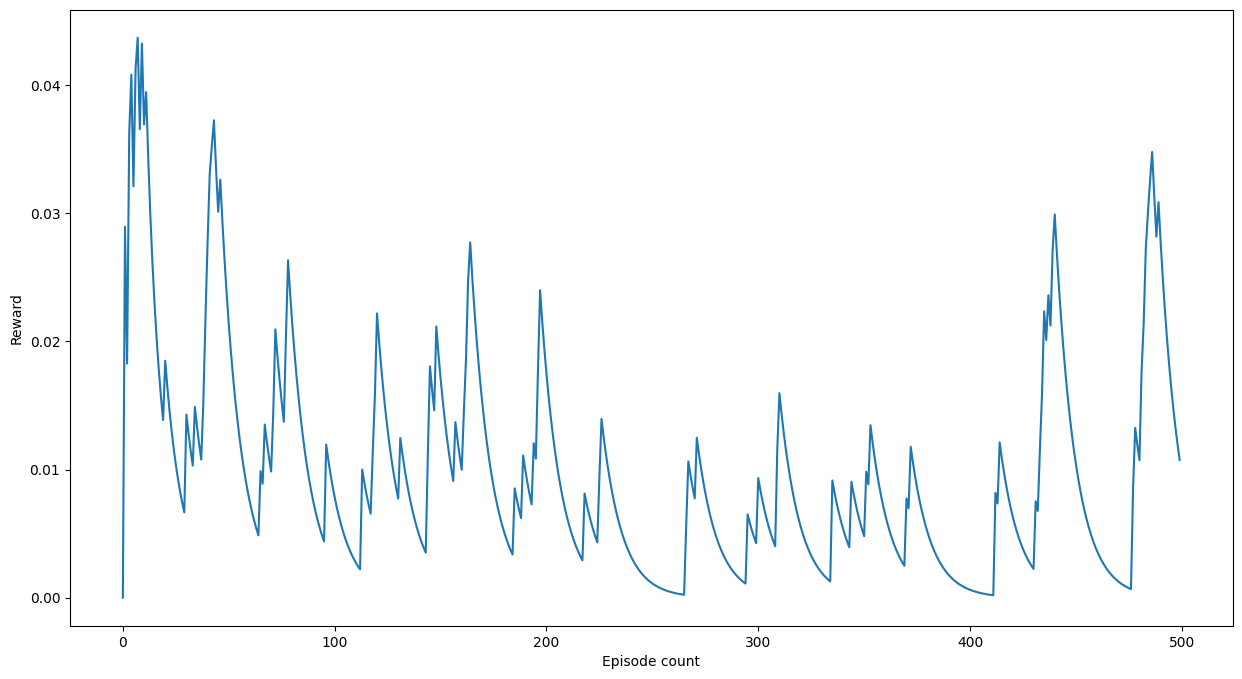

In [9]:
n = 6
ms = 16
episodes = 500
actions = 2
agent = PSAgent(2+n, actions)
episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)
    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        ep_reward += reward
    episode_rewards.append(ep_reward)
plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

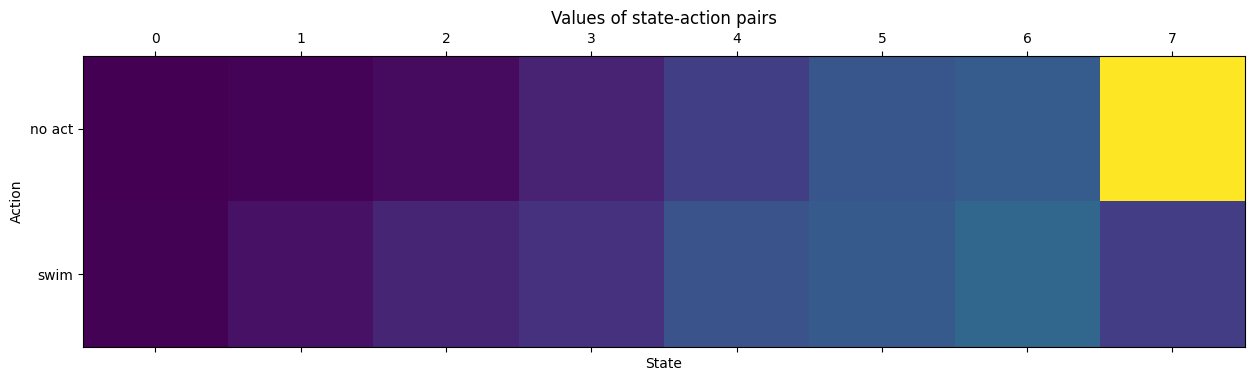

In [10]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

Очень странно, агент плывёт направо, но в самом конце сдаётся. Попробуем увеличить длительность игры.

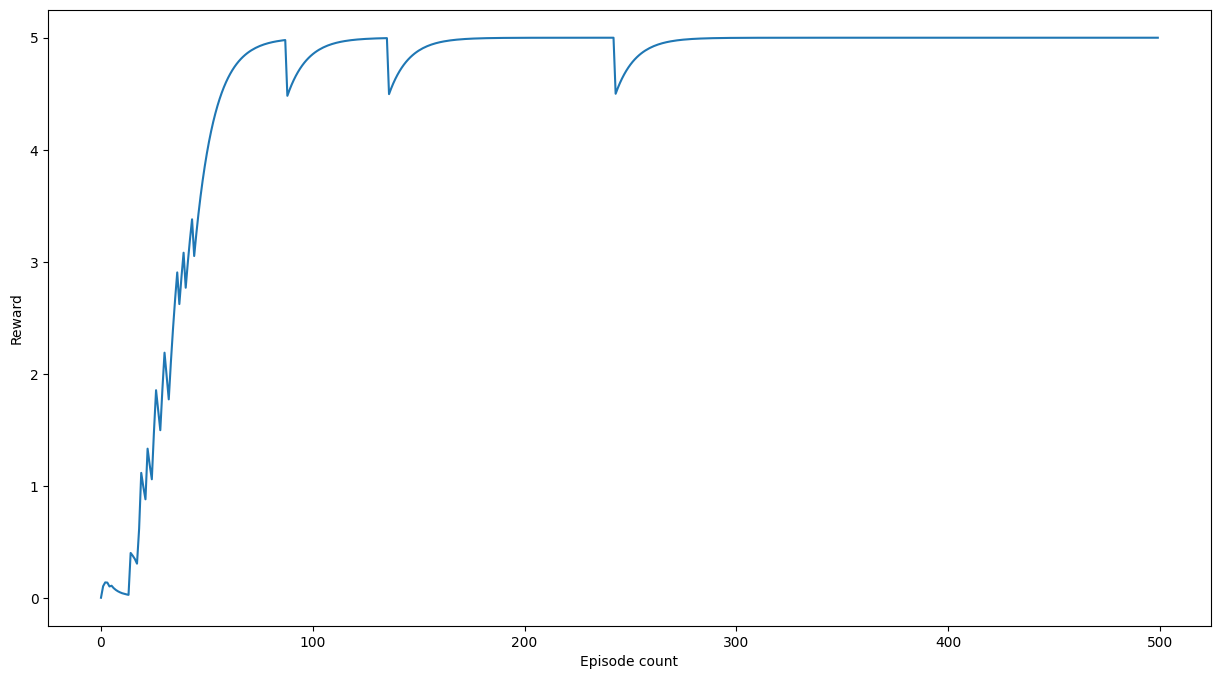

In [11]:
n = 6
ms = 40
episodes = 500
actions = 2
agent = PSAgent(2+n, actions)
episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)
    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        ep_reward += reward
    episode_rewards.append(ep_reward)
plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

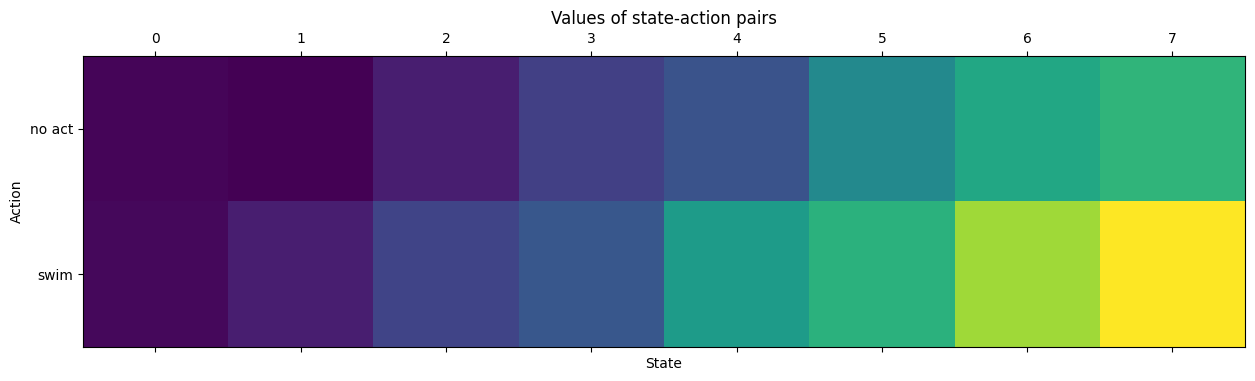

In [12]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

Да, теперь агент снова понимает оптимальную тактику.

### Длинная река и много шагов, сравнение агентов

Покажем, что улучшенный агент достигает цели при увеличении длины реки и длительности игры, а обычный - нет. Причём дадим обычному агенту больше эпизодов для обучения и больше шагов в каждом эпизоде.

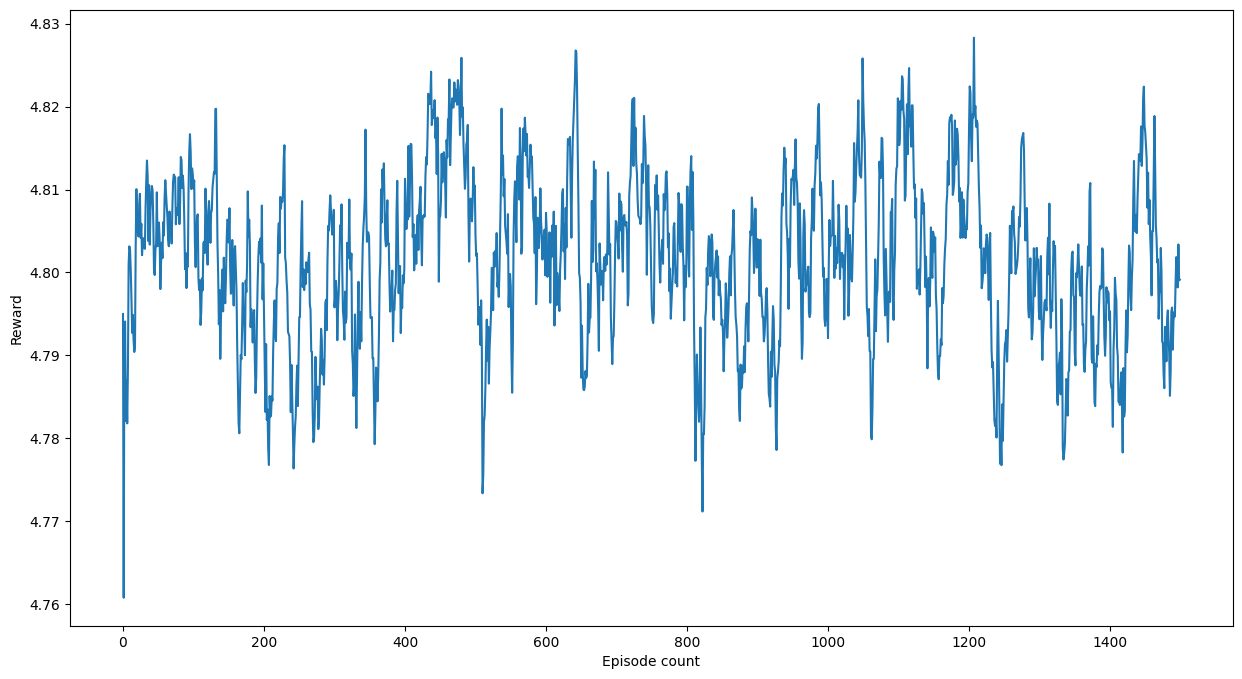

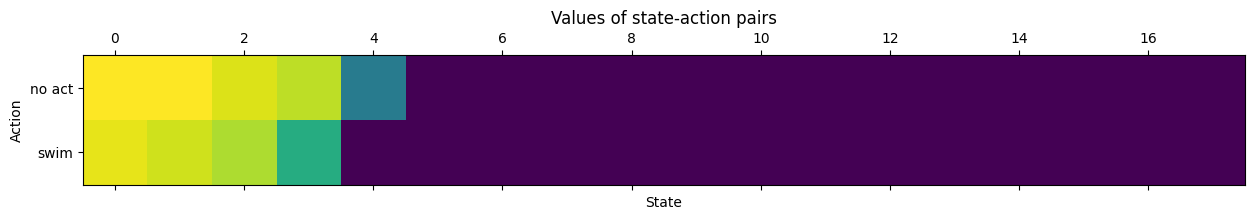

In [13]:
n = 16
ms = 1024
episodes = 1500
actions = 2
agent = QLearningAgent(2+n, actions)
episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)
    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        ep_reward += reward
    episode_rewards.append(ep_reward)
plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

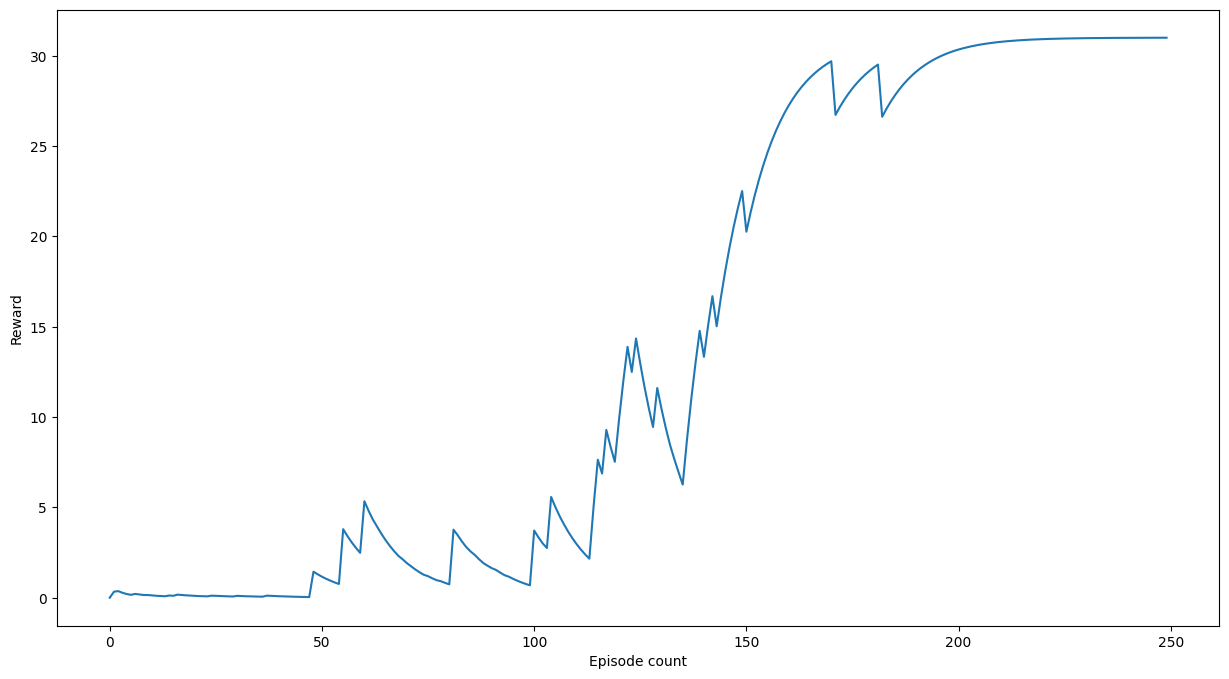

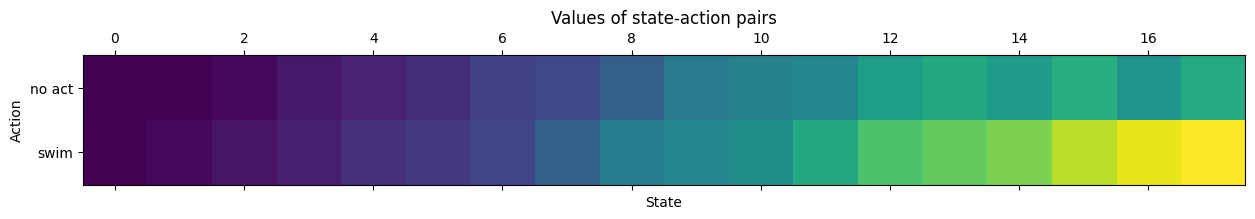

In [14]:
n = 16
ms = 128
episodes = 250
actions = 2
agent = PSAgent(2+n, actions)
episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)
    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        ep_reward += reward
    episode_rewards.append(ep_reward)
plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

### Ещё один эксперимент (вместо увеличения числа шагов чуть-чуть уменьшим реку)

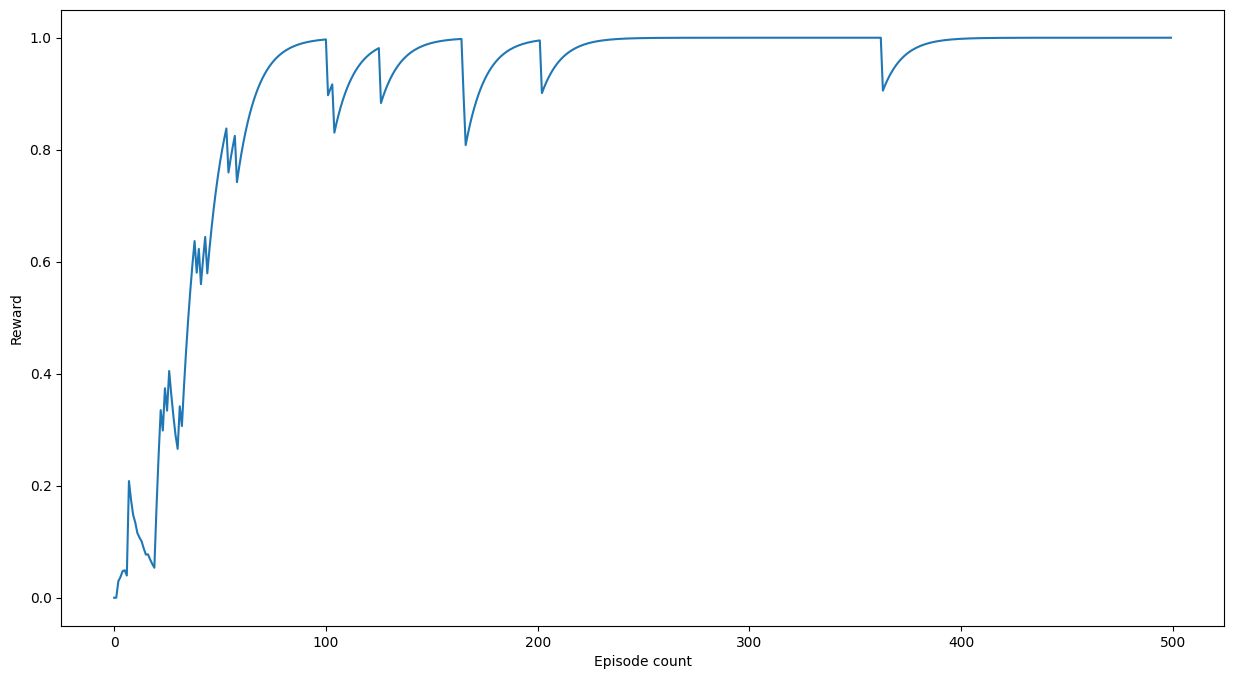

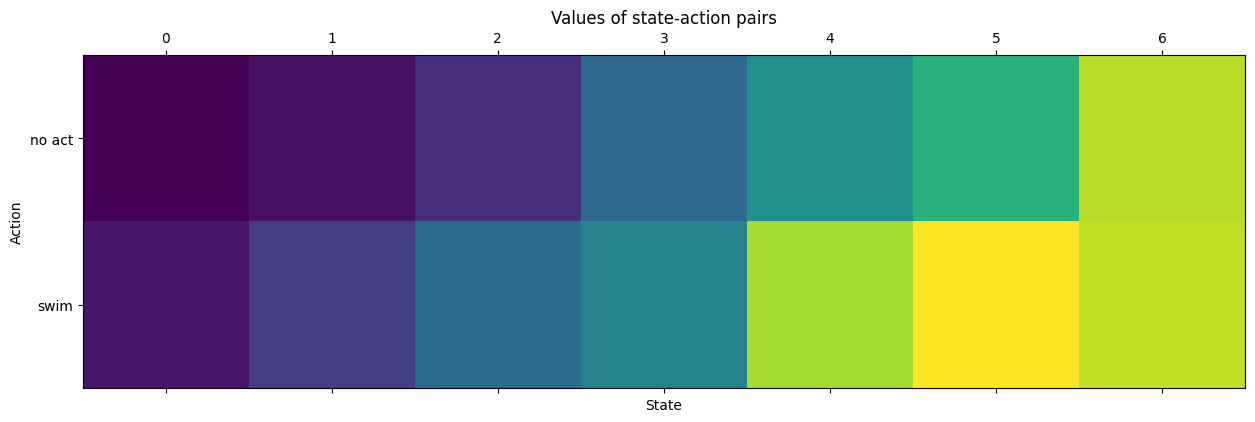

In [15]:
n = 5
ms = 16
episodes = 500
actions = 2
agent = PSAgent(2+n, actions)
episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)
    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        ep_reward += reward
    episode_rewards.append(ep_reward)
plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

In [16]:
agent.get_q_matrix()

array([[72.58856704, 72.67870803],
       [72.64947325, 72.86410726],
       [72.79421237, 73.12152835],
       [73.10594917, 73.26277167],
       [73.35126968, 73.90113775],
       [73.54930343, 74.09670318],
       [73.93376951, 73.95401662]])

Как видим, в крайнем правом положении агент правильно предпочитает пытаться плыть.